# Проект №3. О вкусной и здоровой пище 


In [927]:
import datetime
import re
import math
from collections import Counter

import pandas as pd
import numpy as np 

from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import category_encoders as ce
import missingno

from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [928]:
DATA_DIR = 'data'
# DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [929]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# для удобства переменуем колонки
data.columns = ['Restaurant_id', 'City', 'Cuisine_Style', 'Ranking', 'Price_Range',
                'Number_of_Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating']

In [930]:
data.sample(5)

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,sample,Rating
32111,id_3128,Prague,"['European', 'Czech']",3135.0,$$ - $$$,8.0,"[['Good beer, fine food, nice service', 'Avera...",/Restaurant_Review-g274707-d7694103-Reviews-Gu...,d7694103,1,4.0
3621,id_3621,Madrid,"['Spanish', 'Mediterranean']",5614.0,$$ - $$$,43.0,"[['We Took a Wrong Turn Somewhere', 'Ok no mor...",/Restaurant_Review-g187514-d4303080-Reviews-La...,d4303080,0,0.0
14103,id_1328,Prague,"['European', 'Czech']",1329.0,$,19.0,"[['Dining for a fair price', 'Cheap'], ['07/27...",/Restaurant_Review-g274707-d7124370-Reviews-Gl...,d7124370,1,4.5
28342,id_6652,London,NaN,6661.0,NaN,9.0,"[['A gem near Covent Garden!!!', 'Exceptional ...",/Restaurant_Review-g186338-d8856081-Reviews-Ch...,d8856081,1,5.0
30026,id_4522,London,"['Fast Food', 'Australian', 'Italian', 'Cafe',...",4530.0,$,108.0,"[['Local tasty food', 'Amazeballs!'], ['12/02/...",/Restaurant_Review-g186338-d2484385-Reviews-Ar...,d2484385,1,4.5


Подробнее по признакам:

- `City`: Город
- `Cuisine Style`: Кухня
- `Ranking`: Ранг ресторана относительно других ресторанов в этом городе
- `Price Range`: Цены в ресторане в 3 категориях
- `Number of Reviews`: Количество отзывов
- `Reviews`: 2 последних отзыва и даты этих отзывов
- `URL_TA`: страница ресторана на 'www.tripadvisor.com'
- `ID_TA`: ID ресторана в TripAdvisor
- `Rating`: Рейтинг ресторана (целевая переменная)

## * * * * Cleaning and Preparing Data * * * *

**Основные характерстики**

In [931]:
data.describe()

,Ranking,Number_of_Reviews,sample,Rating
count,50000.000000,46800.000000,50000.000000,50000.000000
mean,3664.427520,124.471197,0.800000,3.194430
std,3700.092452,294.114345,0.400004,1.705453
min,1.000000,2.000000,0.000000,0.000000
25%,972.000000,9.000000,1.000000,3.000000
50%,2278.000000,33.000000,1.000000,4.000000
75%,5241.000000,115.000000,1.000000,4.500000
max,16444.000000,9660.000000,1.000000,5.000000


In [932]:
data.describe(include='object')

,Restaurant_id,City,Cuisine_Style,Price_Range,Reviews,URL_TA,ID_TA
count,50000,50000,38410,32639,49998,50000,50000
unique,13094,31,10731,3,41857,49963,49963
top,id_436,London,['Italian'],$$ - $$$,"[[], []]",/Restaurant_Review-g187514-d7809594-Reviews-La...,d2360290
freq,19,7193,1332,23041,8112,2,2


**Поиск дубликатов**

In [933]:
duplicates = data.duplicated(['ID_TA', 'URL_TA', 'City'], keep=False)
if duplicates.sum() > 0:
    print("Кол-во потенциальных дублей: ", duplicates.sum() / 2)
    display(data[duplicates].sort_values(['ID_TA', 'URL_TA', 'City']).head(6))
else:
    print("Нет дублей")

Кол-во потенциальных дублей:  37.0


,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,sample,Rating
23980,id_3239,Madrid,NaN,3241.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,1,5.0
48946,id_3242,Madrid,NaN,3244.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,1,5.0
4534,id_4534,Madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",1253.0,$$$$,116.0,"[['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,d1028622,0,0.0
28388,id_1229,Madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",1231.0,$$$$,116.0,"[['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,d1028622,1,4.0
118,id_118,Warsaw,['Italian'],1801.0,$,3.0,"[[], []]",/Restaurant_Review-g274856-d10316215-Reviews-B...,d10316215,0,0.0
36920,id_1800,Warsaw,['Italian'],1801.0,$,3.0,"[[], []]",/Restaurant_Review-g274856-d10316215-Reviews-B...,d10316215,1,3.5


Можно попробовать удалить дубли при обработке тренинговых данных.

**Поиск и визуализация данных с пустыми (NaN) значениями**

Датасет включает 11 признаков. 4 содержат NaN значения.


,Missing Values,% of Total Values
Price_Range,17361,34.72
Cuisine_Style,11590,23.18
Number_of_Reviews,3200,6.40
Reviews,2,0.00


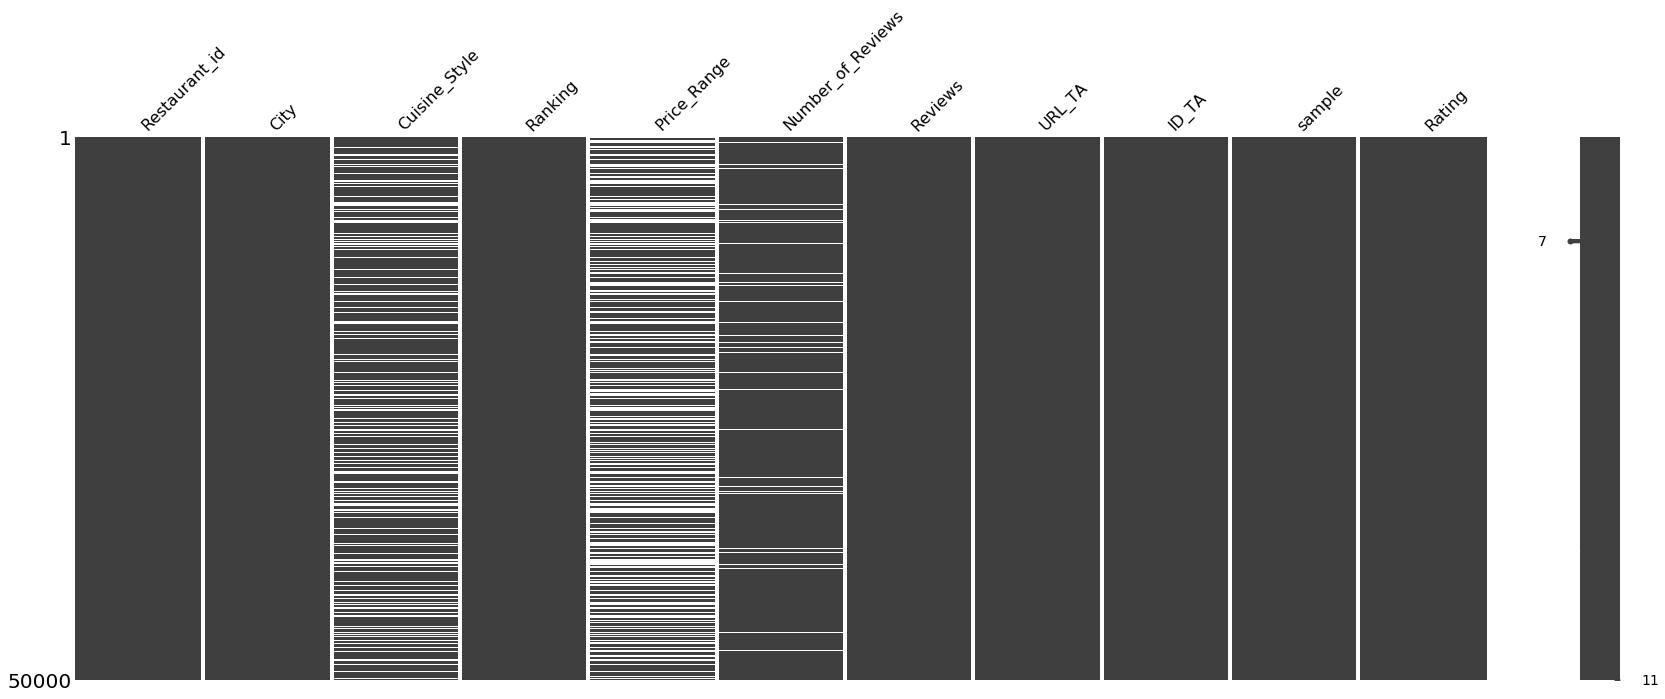

In [934]:
def missing_values_table(df):
    missing_numbers = df.isnull().sum()
    missing_percents = df.isnull().sum() / len(df) * 100
    missing_percents = missing_percents.apply(lambda x: round(x, 2))
    missing_table = pd.concat([missing_numbers, missing_percents], axis=1)
    missing_table.columns = ['Missing Values', '% of Total Values']
    return missing_table[missing_table['Missing Values'] != 0].sort_values(by='% of Total Values', ascending=False)


mis_val_df = missing_values_table(data)
print("Датасет включает " + str(data.shape[1]) + " признаков. " + str(
    mis_val_df.shape[0]) + " содержат NaN значения.")
display(mis_val_df)

if len(data.isnull().any(axis=1) != 0):
    missingno.matrix(data)
    plt.show()

Так как кол-во пустых значений большое, то их удаление нежелательно. Необходимо будет определить алгоритмы заполнения.

In [935]:
# Обрабатываем пустые значения и кодируем признаки
data['Reviews'].fillna('', inplace=True)
data['Price_Range'].fillna(0, inplace=True)
data['Number_of_Reviews'].fillna(0, inplace=True)
data['Cuisine_Style'].fillna('Miscellaneous', inplace=True)
price_dict = {"0": 0, "$": 1, "$$ - $$$": 2, "$$$$": 3}
data['Price_Range_Code'] = data['Price_Range'].replace(to_replace=price_dict)

**Обработка нечисловых признаков**

`Cuisine_Style`

In [936]:
def get_top10_cuisines(сuisine_styles):
    cuisines = set()
    for cuisine_style in сuisine_styles:
        for cuisine in cuisine_style:
            cuisines.add(cuisine)

    cuisines_counter = Counter()
    for cuisines in сuisine_styles:
        for cuisine in cuisines:
            cuisines_counter[cuisine] += 1

    return pd.DataFrame(cuisines_counter.most_common(10))[0].tolist()


def is_top10_cuisine(cuisine_style, top10_cuisines):
    for cuisine in top10_cuisines:
        if cuisine in cuisine_style:
            return 1
        else:
            continue
    return 0

# парсинг `Cuisine Style` для сохранения в list
data['Cuisine_Style'] = data['Cuisine_Style'].apply(lambda x: re.findall('\w+\s*\w+\s*\w+', str(x)))
# получить top-10 кухонь
top10_cuisines = get_top10_cuisines(data['Cuisine_Style'])
# кол-во представленных в ресторане кухонь мира
data['Count_Cuisines'] = data['Cuisine_Style'].apply(lambda x: len(x))    
# кухни ресторана входят в TOP10 представленных кухонь датасета
data['Top10_Cuisine'] = data['Cuisine_Style'].apply(lambda x: is_top10_cuisine(x,top10_cuisines))

## * * * * Exploratory Data Analysis (EDA) * * * *

**Анализ основных характерстик**

In [937]:
data.describe()

,Ranking,Number_of_Reviews,sample,Rating,Price_Range_Code,Count_Cuisines,Top10_Cuisine
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,3664.427520,116.505040,0.800000,3.194430,1.184880,2.625860,0.832640
std,3700.092452,286.173104,0.400004,1.705453,0.957308,1.824386,0.373301
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,972.000000,7.000000,1.000000,3.000000,0.000000,1.000000,1.000000
50%,2278.000000,28.000000,1.000000,4.000000,1.000000,2.000000,1.000000
75%,5241.000000,105.000000,1.000000,4.500000,2.000000,4.000000,1.000000
max,16444.000000,9660.000000,1.000000,5.000000,3.000000,21.000000,1.000000


In [938]:
data.describe(include=[object])

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


,Restaurant_id,City,Cuisine_Style,Price_Range,Reviews,URL_TA,ID_TA
count,50000,50000,50000,50000,50000,50000,50000
unique,13094,31,10732,4,41858,49963,49963
top,id_436,London,[Miscellaneous],$$ - $$$,"[[], []]",/Restaurant_Review-g187514-d7809594-Reviews-La...,d2360290
freq,19,7193,11590,23041,8112,2,2


В признаках `Ranking` и `Number_of_Reviews` могуть быть выбросы, так как размах между 75% и максимум большой.

**Поиск выбросов**

In [939]:
def define_outlers(column):
    print(column.name)
    quartile_1, median, quartile_3 = column.quantile([0.25, 0.5,  0.75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    maximum = column.max()
    minimum = column.min()
    print(f'25-й перцентиль - {quartile_1} / 75-й перцентиль - {quartile_3} / IQR - {iqr}')
    print(f'Границы выбросов - [{lower_bound}, {upper_bound}]')
    print(f'Кол-во max выбросов - {column[column > upper_bound].count()}')
    print(f'Кол-во min выбросов - {column[column < lower_bound].count()}')
    print(f'Минимум - {minimum}')
    print(f'Максимум - {maximum}')


define_outlers(data['Number_of_Reviews'])
print('---')
define_outlers(data['Ranking'])

Number_of_Reviews
25-й перцентиль - 7.0 / 75-й перцентиль - 105.0 / IQR - 98.0
Границы выбросов - [-140.0, 252.0]
Кол-во max выбросов - 5946
Кол-во min выбросов - 0
Минимум - 0.0
Максимум - 9660.0
---
Ranking
25-й перцентиль - 972.0 / 75-й перцентиль - 5241.0 / IQR - 4269.0
Границы выбросов - [-5431.5, 11644.5]
Кол-во max выбросов - 3075
Кол-во min выбросов - 0
Минимум - 1.0
Максимум - 16444.0


Выбросы смотрим по количественным признакам `Number_of_Reviews` и `Ranking`. Можно попробовать удалить выбросы и посмотреть как это повлияет на точность модели. Лучше использовать более высокую границы выбросов > quartile +- (iqr * 1.5)

**Гистограммы распределения каждого признака**


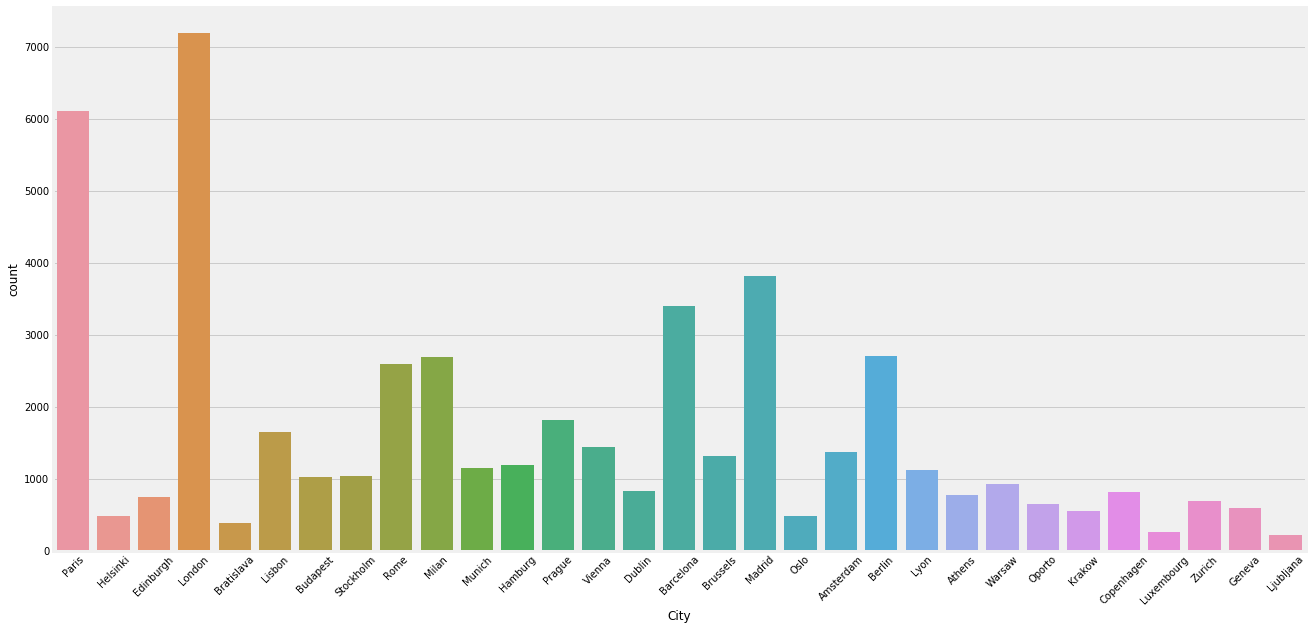

In [940]:
fig, ax = plt.subplots(figsize=(20, 10))    
sns.countplot(x='City', data=data);
plt.xticks(rotation=45)
plt.show()

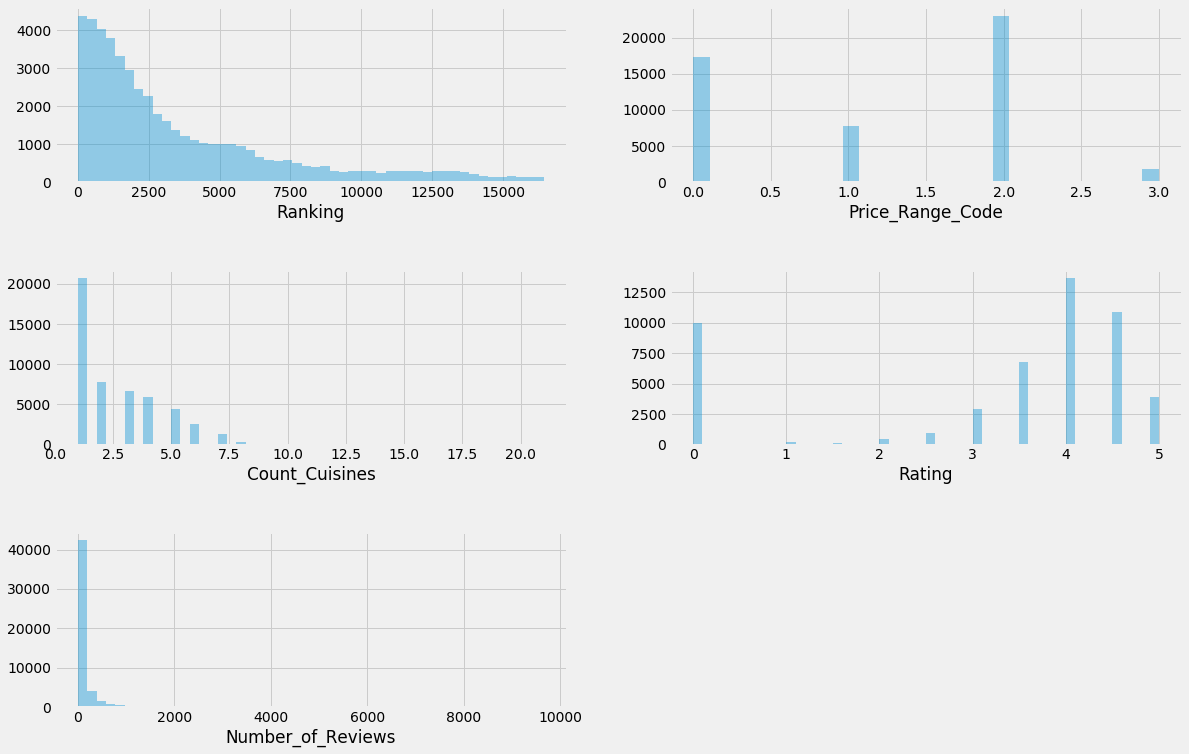

In [941]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(left=None, bottom=None, right=None,
                        top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
        else:
            g = sns.distplot(dataset[column], kde=False)


cols_for_plot = ['Ranking', 'Price_Range_Code',
                 'Count_Cuisines', 'Rating', 'Number_of_Reviews']
plot_distribution(data[cols_for_plot], cols=2, width=18,
                  height=12, hspace=0.5, wspace=0.2)

Анализ `Ranking`

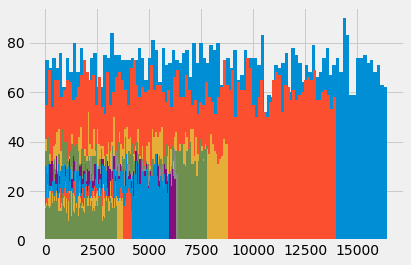

In [942]:
# посмотрим на топ 10 городов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

Получается, что `Ranking` имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение необходимо отнормировать критерий `Ranking` по городам `City`.

In [943]:
mean_value = data.groupby('City')['Ranking'].mean()
std_value = data.groupby('City')['Ranking'].std()
data['Ranking_City_Std'] = (data['Ranking'] - data['City'].map(mean_value))/data['City'].map(std_value)

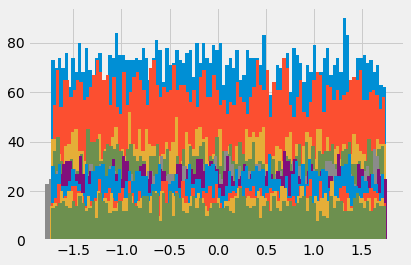

In [944]:
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking_City_Std'][data['City'] == x].hist(bins=100)
plt.show()

**Анализ отношения целевой переменой к другим признакам**

`City`

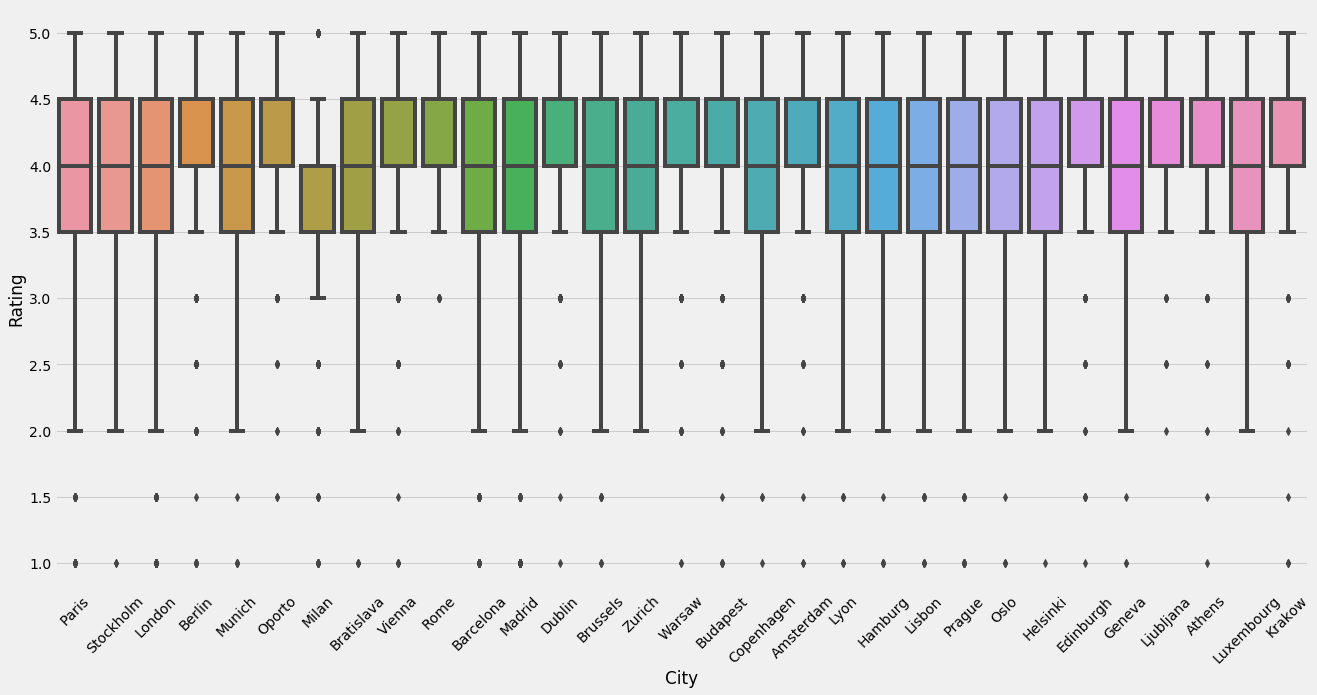

In [945]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x='City', y='Rating', data=data[data['sample'] > 0], ax=ax)
plt.xticks(rotation=45)
plt.show()

По графикам получается, что `City` не сильно влияет на `Rating` 

`Top10_Cuisine` и `Count_Cuisines`

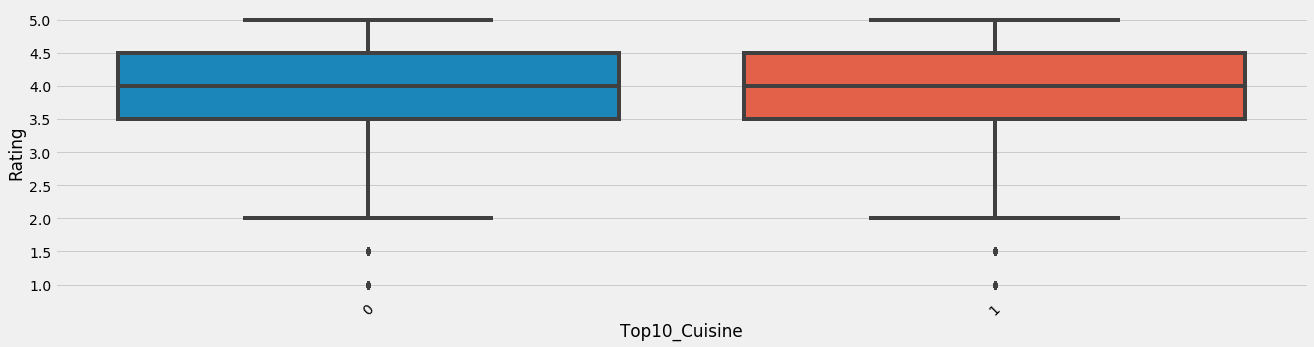

In [946]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(x='Top10_Cuisine', y='Rating', data=data[data['sample'] > 0], ax=ax)
plt.xticks(rotation=45)
plt.show()

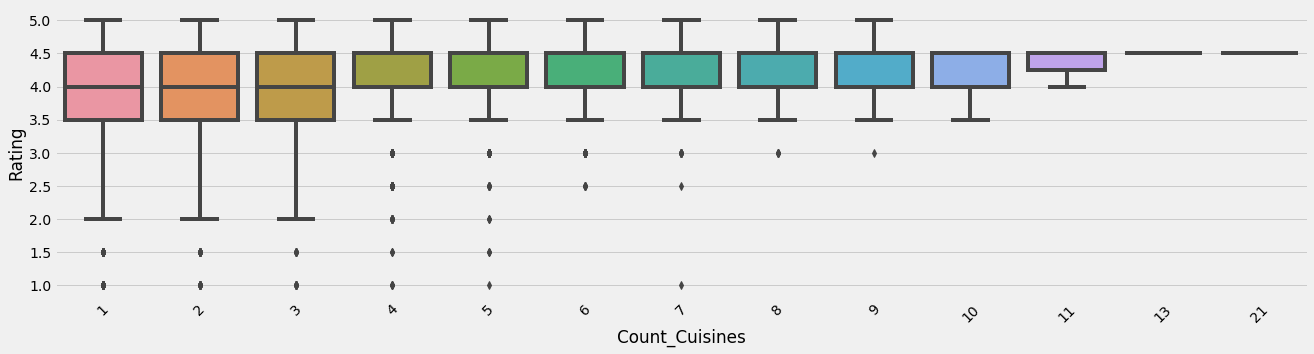

In [947]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(x='Count_Cuisines', y='Rating', data=data[data['sample'] > 0], ax=ax)
plt.xticks(rotation=45)
plt.show()

Кол-во, представленных в ресторанах кухонь влияет на рейтинг.

`Price_Range_Code`/`Price_Range`

In [949]:
pd.crosstab(data['Price_Range_Code'], data.Rating, margins=True).style.background_gradient(cmap='autumn_r')

Rating,0.0,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,All
Price_Range_Code,,,,,,,,,,,
0,3475,165,96,320,523,1463,2130,3873,3094,2222,17361
1,1537,14,10,51,121,349,954,1955,2137,688,7816
2,4629,18,32,91,264,1117,3615,7331,5078,866,23041
3,359,4,1,4,7,26,125,533,620,103,1782
All,10000,201,139,466,915,2955,6824,13692,10929,3879,50000


Больше всего максимальных оценок для ресторанов в которых отсутствует ценовая категория. В среднем более положительные оценки получают рестораны в средней ценовой категории.

**Корреляционный анализ числовых признаков**

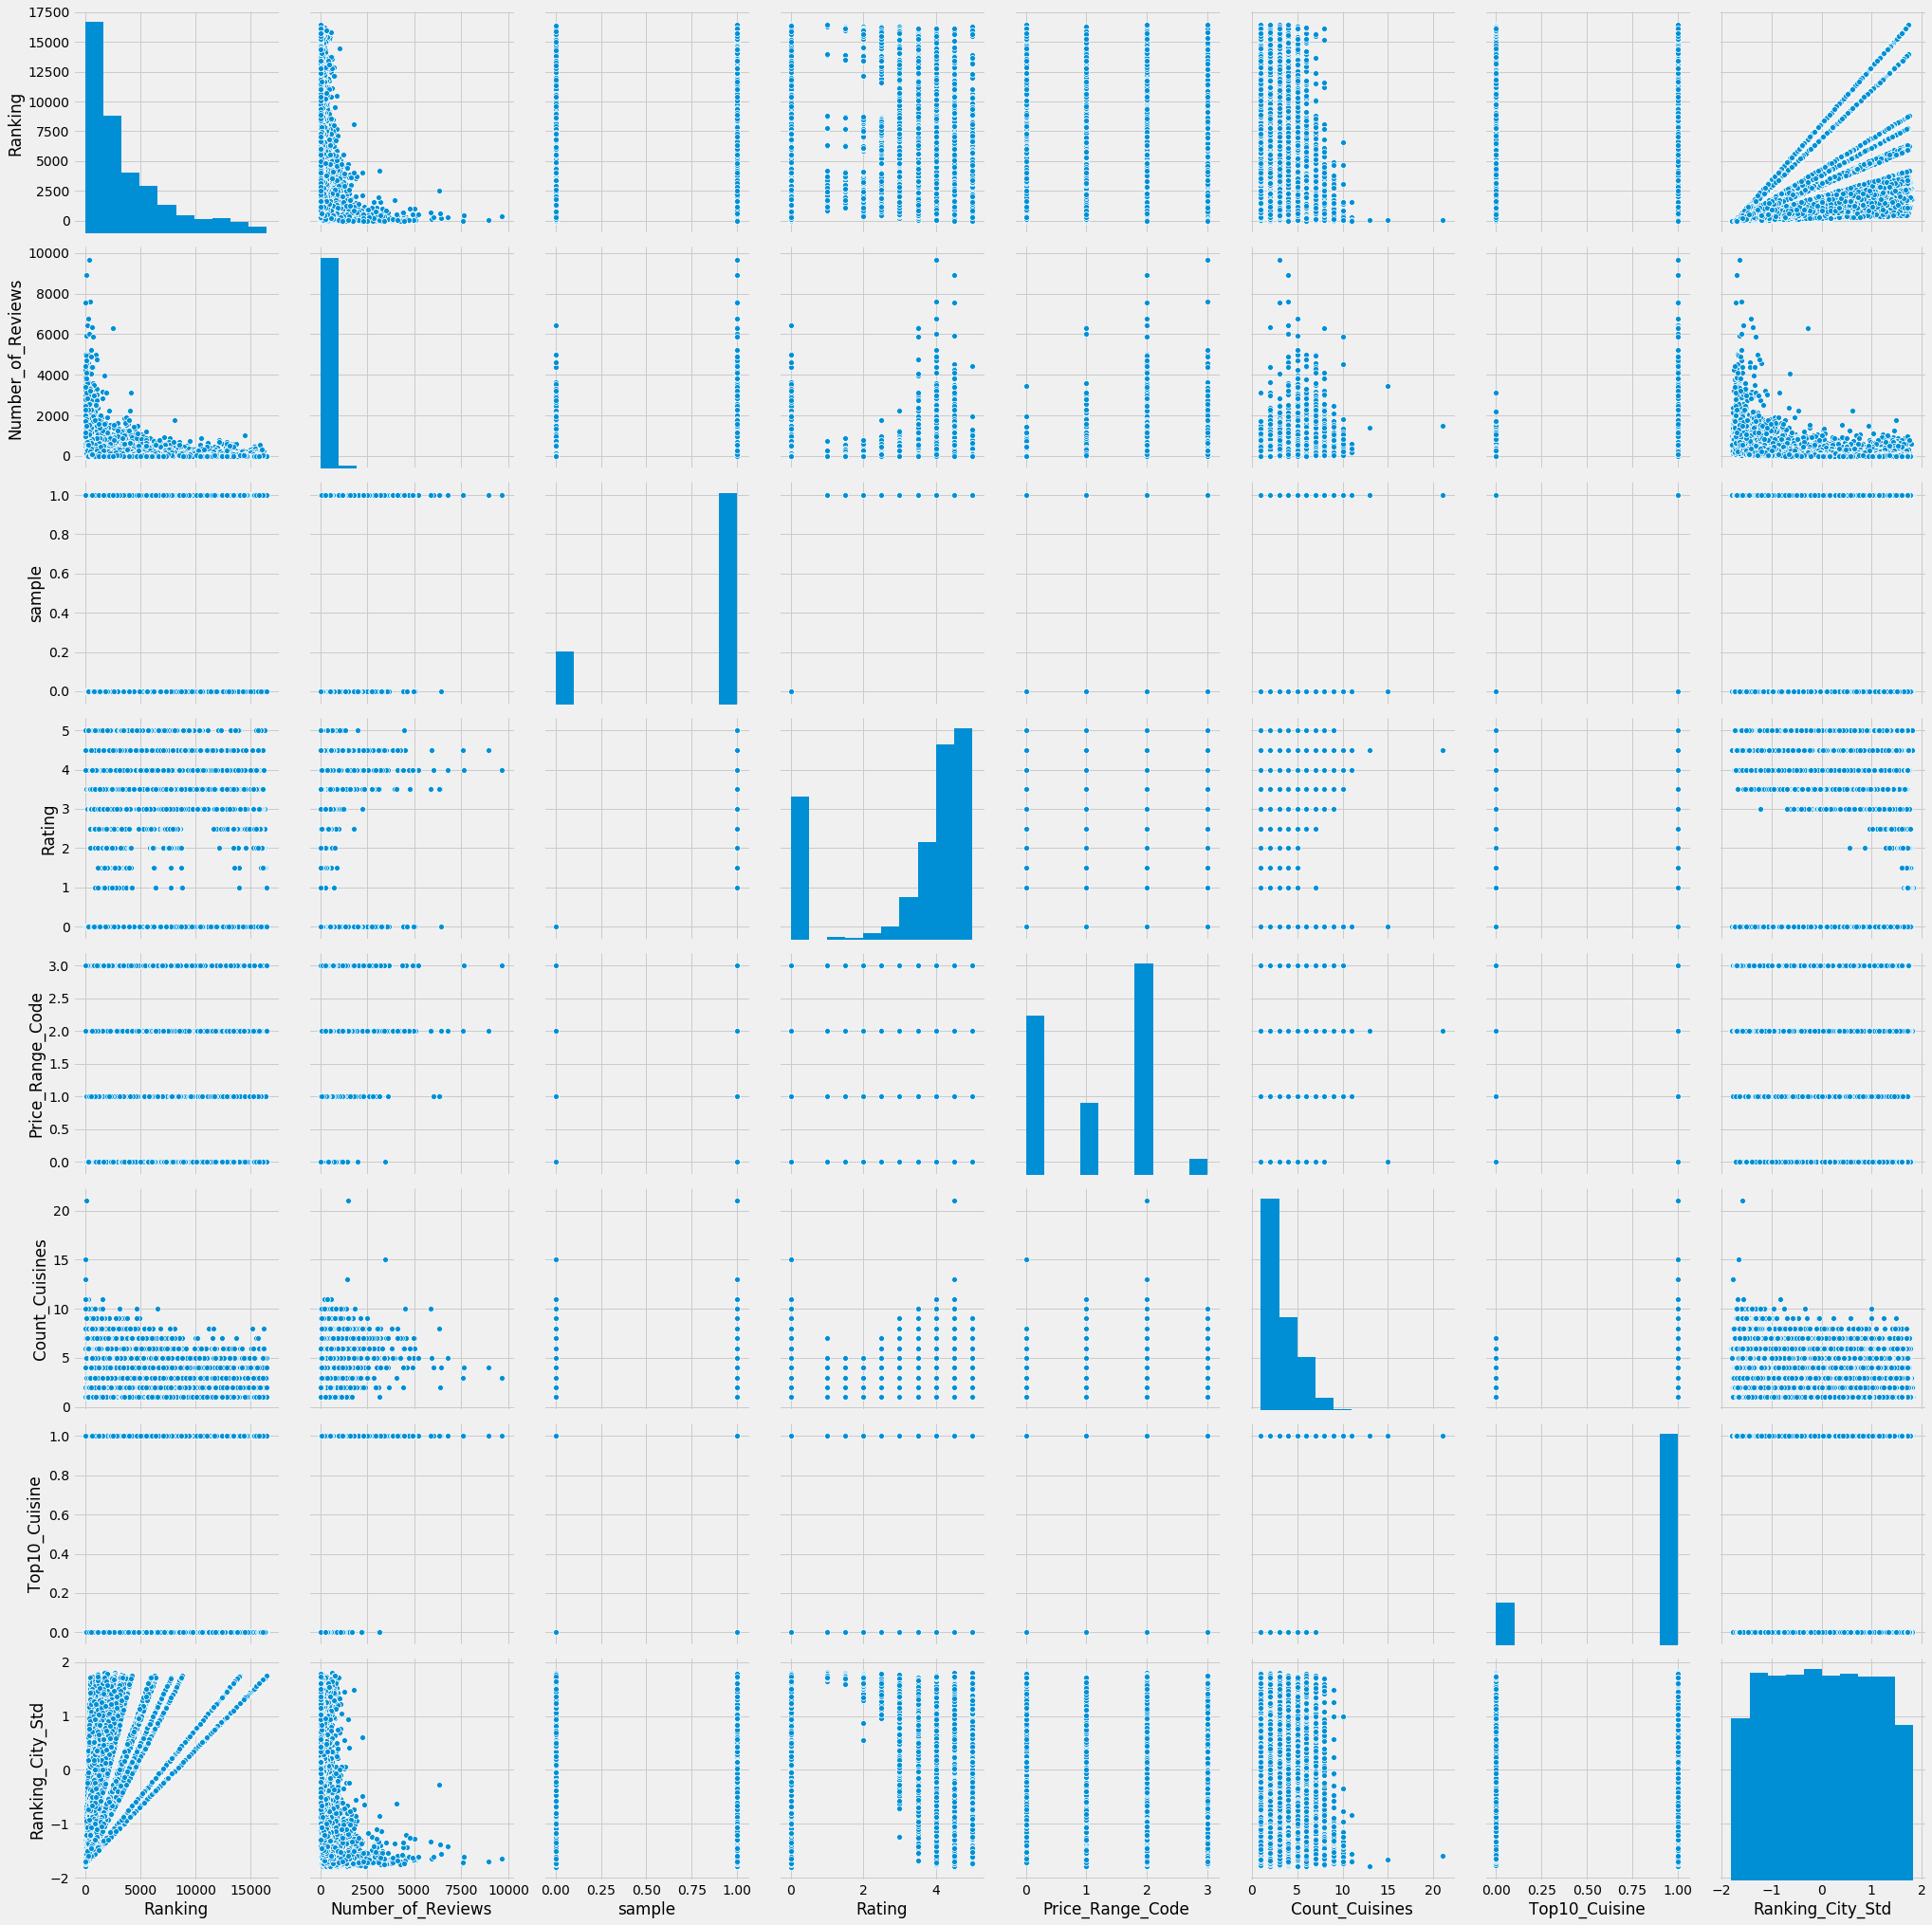

In [950]:
sns.pairplot(data, height=3.5);

,Ranking,Number_of_Reviews,Rating
Ranking,1.000000,-0.223198,-0.109897
Number_of_Reviews,-0.223198,1.000000,0.011006
Rating,-0.109897,0.011006,1.000000


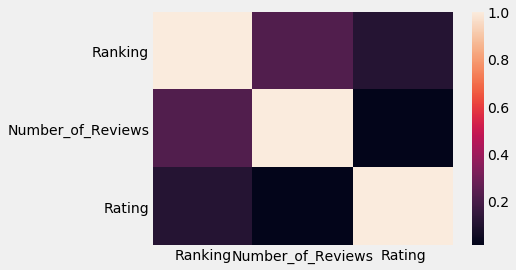

In [951]:
corr = data[['Ranking','Number_of_Reviews','Rating']].corr()
display(corr)
sns.heatmap(abs(corr));

Нет сильной корреляции целевого признака `Rating` от остальных. 

## * * * * Data Preprocessing * * * *

**Загрузка данных и первоначальные установки**

In [1068]:
RANDOM_SEED = 42

df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1
df_test['sample'] = 0
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)  # объединяем
data.columns = ['Restaurant_id', 'City', 'Cuisine_Style', 'Ranking', 'Price_Range',
                'Number_of_Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating']

# загружаем датасеты с дополнительными данными
wolrdcities_df = pd.read_csv(DATA_DIR+'/worldcities.csv')
# wolrdcities_df = pd.read_csv('../input/world-cities/worldcities.csv')

display(data.info())
data.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine_Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price_Range        32639 non-null  object 
 5   Number_of_Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


None

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0
5,id_5,Paris,"['French', 'Cafe', 'Fast Food']",5093.0,$,24.0,"[['Lunch Break', 'Good to Quick Bite'], ['09/0...",/Restaurant_Review-g187147-d8458643-Reviews-Le...,d8458643,0,0.0
6,id_6,Lisbon,"['European', 'Portuguese']",3704.0,$,2.0,"[[], []]",/Restaurant_Review-g189158-d8758873-Reviews-Li...,d8758873,0,0.0
7,id_7,Budapest,NaN,2330.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,0.0
8,id_8,Helsinki,"['European', 'Scandinavian']",771.0,NaN,2.0,"[['Big group supper', 'Good food but very slow...",/Restaurant_Review-g189934-d12947542-Reviews-B...,d12947542,0,0.0
9,id_9,Stockholm,['Italian'],605.0,NaN,13.0,"[['Good food', 'Good pizza'], ['12/02/2017', '...",/Restaurant_Review-g189852-d12716384-Reviews-I...,d12716384,0,0.0


In [1069]:
# для ускорение работы процедуры обработки данных
try:
    save_cols_df['Days_to_Now'] = df_preproc['Days_to_Now']
    save_cols_df['Days_bt_Reviews'] = df_preproc['Days_bt_Reviews']
    save_cols_df['Reviews_Polarity'] = df_preproc['Reviews_Polarity']
    save_cols_df['MinMax_Ranking_in_City'] = df_preproc['MinMax_Ranking_in_City']
except NameError:
    save_cols_df = pd.DataFrame()
save_cols_df

,Days_to_Now,Days_bt_Reviews,Reviews_Polarity,MinMax_Ranking_in_City
0,0.0,0,0.000000,0.927
1,1016.0,37,0.708333,0.090
2,993.0,22,0.166667,0.458
3,1015.0,14,0.750000,0.101
4,951.0,15,0.955000,0.038
...,...,...,...,...
49995,1005.0,34,0.666667,0.080
49996,1000.0,9,0.600000,0.453
49997,1413.0,3127,0.177778,0.670
49998,1163.0,23,0.000000,0.297


**Служебные функции для Data Preprocessing**

In [1070]:
def prep_cities_population():
    wolrdcities_df.loc[wolrdcities_df['city_ascii'] == 'Porto', 'city_ascii'] = 'Oporto'
    wolrdcities_df.loc[wolrdcities_df['city_ascii'] == 'Kobenhavn', 'city_ascii'] = 'Copenhagen'
    cities_population_df = wolrdcities_df[wolrdcities_df['city_ascii'].isin(
        list(data.City.unique()))][['city_ascii', 'country', 'population']] #,'lat','lng']]
    index_to_delete = cities_population_df[cities_population_df['country'] == 'United States'].index
    cities_population_df.drop(index_to_delete, inplace=True)
    cities_population_df.drop([3799, 5327], inplace=True)
    if len(cities_population_df.sort_values('city_ascii')) != len(list(data.City.unique())):
        raise Exception('length cities doesn\'t equal')
    cities_population_df.columns = ['City', 'Country', 'Population']    
    return cities_population_df


def get_top10_cuisines(сuisine_styles):
    cuisines = set()
    for cuisine_style in сuisine_styles:
        for cuisine in cuisine_style:
            cuisines.add(cuisine)

    cuisines_counter = Counter()
    for cuisines in сuisine_styles:
        for cuisine in cuisines:
            cuisines_counter[cuisine] += 1

    return pd.DataFrame(cuisines_counter.most_common(10))[0].tolist()


def is_top10_cuisine(cuisine_style, top10_cuisines):
    for cuisine in top10_cuisines:
        if cuisine in cuisine_style:
            return 1
        else:
            continue
    return 0


def get_days_bt_reviews(dates):
    if len(dates) == 2:
        delta = pd.to_datetime(dates[1]) - pd.to_datetime(dates[0])
        return abs(delta.days)
    return 0


def get_days_to_now(dates):
    delta = datetime.datetime.now() - pd.to_datetime(dates).max() 
    return delta.days


def minmax_scaler_ranking(row, rank_city_minmax):
    city_min = rank_city_minmax[rank_city_minmax['City'] == row.City ]['min'].iloc[0]
    city_max = rank_city_minmax[rank_city_minmax['City'] == row.City ]['max'].iloc[0]
    return round((row['Ranking'] - city_min)/(city_max - city_min),3)

**Основная функция для подготовки данных**

In [1071]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()
    
    # удаляем выбросы Ranking > 14500  
#     df_output = df_output[df_output.Ranking < 15000]
#     df_output = df_output[(df_output.Ranking < 15000) & (df_output['sample'] == 1)]
    
    # ***** Работа с NAN *****

    # Пропущенные NaN заполняем нулями/'' и также вводим признак наличие NaN
    df_output['Number_of_Reviews_NaN'] = pd.isna(df_output['Number_of_Reviews']).astype('float64')
    df_output['Number_of_Reviews'].fillna(0, inplace=True)
    df_output['Reviews_NaN'] = pd.isna(df_output['Reviews']).astype('float64')
    df_output['Reviews'].fillna('', inplace=True)
    df_output['Price_Range_NaN'] = pd.isna(df_output['Price_Range']).astype('float64')
    df_output['Price_Range'].fillna(0, inplace=True)

    # `Cuisine Style` NaN заполняем значением Miscellaneous 
    df_output['Cuisine_Style'].fillna('Miscellaneous', inplace=True)
    
    
    # ***** Предобработка *****
    
    # парсинг `Cuisine Style` для сохранения в list
    df_output['Cuisine_Style'] = df_output['Cuisine_Style'].apply(lambda x: re.findall('\w+\s*\w+\s*\w+', str(x)))
    # выделение текста отзыва
    df_output['Reviews_Text'] = df_output['Reviews'].apply(lambda x: re.findall('\[\'.+\'\],', str(x)))
    # получить top-10 кухонь
    top10_cuisines = get_top10_cuisines(df_output['Cuisine_Style'])


    # ***** Feature Engineering *****

    # `Price Range` ординальный признак кодируем 
    price_dict = {"0": 0, "$": 1, "$$ - $$$": 2, "$$$$": 3}
    df_output['Price_Range_Code'] = df_output['Price_Range'].replace(to_replace=price_dict)

    # кол-во представленных в ресторане кухонь мира
    df_output['Count_Cuisines'] = df_output['Cuisine_Style'].apply(lambda x: len(x))    
    # кухни ресторана входят в TOP10 представленных кухонь датасета
    df_output['Top10_Cuisine'] = df_output['Cuisine_Style'].apply(lambda x: is_top10_cuisine(x,top10_cuisines))
    
    # кол-во населения в городе где находится ресторан
    df_output = pd.merge(df_output, prep_cities_population(), on='City', how='left')
    df_output.rename(columns={'Population': 'City_Population'}, inplace=True)
    
    # кол-во дней между отзывами
    df_output['Review_Dates'] = df_output['Reviews'].str.findall('\d+/\d+/\d+')
    %time df_output['Days_bt_Reviews'] = df_output['Review_Dates'].apply(get_days_bt_reviews)
    # кол-во дней от последнего отзыва до сегодня
    %time df_output['Days_to_Now'] = df_output['Review_Dates'].apply(get_days_to_now)
    df_output['Days_to_Now'].fillna(0, inplace=True)  
#     df_output['Days_bt_Reviews'] = save_cols_df.Days_bt_Reviews
#     df_output['Days_to_Now'] = save_cols_df.Days_to_Now
    
    # определение тональности отзывов
    %time df_output['Reviews_Polarity'] = df_output['Reviews_Text'].apply(lambda x: TextBlob(x[0]).sentiment.polarity if len(x) > 0 else 0)
#     df_output['Reviews_Polarity'] = save_cols_df.Reviews_Polarity
    
    
    # кол-во ресторанов в стране
    restorants_in_country = df_output.groupby('Country')['Restaurant_id'].count().to_dict()
    df_output['Restorants_in_Country'] = df_output['Country'].map(restorants_in_country)
    # кол-во ресторанов в городе
    restorants_in_city = df_output.groupby('City')['Restaurant_id'].count().to_dict()
    df_output['Restorants_in_City'] = df_output['City'].map(restorants_in_city)
    # средняя цена по ресторанам города
    price_in_city = df_output.groupby('City')['Price_Range_Code'].mean().to_dict()
    df_output['Price_in_City'] = df_output['City'].map(price_in_city)
    # средняя кол-во отзывово по ресторанам города
    reviews_in_city = df_output.groupby('City')['Number_of_Reviews'].mean().to_dict()
    df_output['Reviews_in_City'] = df_output['City'].map(reviews_in_city)
    
    # средняя `Ranking` города
    ranking_in_city = df_output.groupby('City')['Ranking'].mean().to_dict()
    df_output['Ranking_in_City'] = df_output['City'].map(ranking_in_city)
    
    # нормализация `Ranking`
    mean_value = df_output.groupby('City')['Ranking'].mean()
    std_value = df_output.groupby('City')['Ranking'].std()
    df_output['Ranking_City_Std'] = (df_output['Ranking'] - df_output['City'].map(mean_value))/df_output['City'].map(std_value)
        
    # комбинация признаков City и Country 
    interactions = df_output['City'] + "_" + df_output['Country']
    encoder = preprocessing.LabelEncoder()
    df_output['City_Country'] = encoder.fit_transform(interactions)

    # сколько ресторанов на каждого жителя города
    df_output['Restorants_Density'] = df_output['Restorants_in_City'] / df_output['City_Population']
        
    # MinMax нормализация Ranking в пределах одного города
    rank_city_minmax = df_output.groupby('City')['Ranking'].agg([min,max])
    rank_city_minmax = rank_city_minmax.reset_index()    
    %time df_output['MinMax_Ranking_in_City'] = df_output.apply(lambda x: minmax_scaler_ranking(x, rank_city_minmax), axis=1)
#     df_output['MinMax_Ranking_in_City'] = save_cols_df.MinMax_Ranking_in_City 

    # ID_TA возможно указывает на связь ресторанов (также есть дубликаты)
    df_output['ID_TA'] = df_output['ID_TA'].apply(lambda x: x[1:]).astype('uint64')

    # добавление полиноминальных признаков
    feature_cols = ['Ranking', 'Number_of_Reviews', 'Ranking_City_Std']
    poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False)
    polynomials = pd.DataFrame(poly.fit_transform(df_output[feature_cols]))
    df_output = pd.concat([df_output, polynomials], axis=1) # polynomials.iloc[:,3:]
    
    
    # ***** Encoding *****
    
    # One-Hot Encoding для City
    df_output = pd.get_dummies(df_output, columns=['City'], dummy_na=True)    
    # One-Hot Encoding для Cuisine_Style
    cuisine_stacked = df_output['Cuisine_Style'].apply(pd.Series).stack()
    cusine_dummy = pd.get_dummies(cuisine_stacked, prefix="cuisine_").sum(level=0)
    df_output = pd.concat([df_output, cusine_dummy], axis=1)

    
    # ***** Clean *****
    
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis=1, inplace=True)

    return df_output

**Обработка данных и проверка результата**

In [1072]:
df_preproc = preproc_data(data) 

In [1073]:
df_preproc.sample(10)

,Ranking,Number_of_Reviews,ID_TA,sample,Rating,Number_of_Reviews_NaN,Reviews_NaN,Price_Range_NaN,Price_Range_Code,Count_Cuisines,...,cuisine__Ukrainian,cuisine__Uzbek,cuisine__Vegan Options,cuisine__Vegetarian Friendly,cuisine__Venezuelan,cuisine__Vietnamese,cuisine__Welsh,cuisine__Wine Bar,cuisine__Xinjiang,cuisine__Yunnan
32783,1834.0,72.0,1905762,1,4.0,0.0,0.0,0.0,2,3,...,0,0,1,1,0,0,0,0,0,0
10955,2408.0,8.0,2549710,1,4.0,0.0,0.0,0.0,2,1,...,0,0,0,0,0,0,0,0,0,0
35812,3159.0,158.0,8813314,1,3.5,0.0,0.0,0.0,2,7,...,0,0,1,1,0,0,0,0,0,0
354,5605.0,5.0,5526751,0,0.0,0.0,0.0,0.0,2,1,...,0,0,0,0,0,0,0,0,0,0
24744,821.0,12.0,10384739,1,4.5,0.0,0.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
22687,103.0,609.0,2631042,1,4.5,0.0,0.0,0.0,2,7,...,0,0,1,1,0,0,0,0,0,0
46262,8808.0,25.0,3907854,1,4.0,0.0,0.0,0.0,2,1,...,0,0,0,0,0,0,0,0,0,0
10681,2946.0,4.0,11958431,1,5.0,0.0,0.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
7577,70.0,1098.0,8021047,0,0.0,0.0,0.0,0.0,2,6,...,0,0,1,1,0,0,0,0,0,0
4911,547.0,109.0,4289917,0,0.0,0.0,0.0,0.0,1,4,...,0,0,0,1,0,0,0,0,0,0


In [1074]:
df_preproc.info(max_cols=210)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 193 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ranking                       50000 non-null  float64
 1   Number_of_Reviews             50000 non-null  float64
 2   ID_TA                         50000 non-null  uint64 
 3   sample                        50000 non-null  int64  
 4   Rating                        50000 non-null  float64
 5   Number_of_Reviews_NaN         50000 non-null  float64
 6   Reviews_NaN                   50000 non-null  float64
 7   Price_Range_NaN               50000 non-null  float64
 8   Price_Range_Code              50000 non-null  int64  
 9   Count_Cuisines                50000 non-null  int64  
 10  Top10_Cuisine                 50000 non-null  int64  
 11  City_Population               50000 non-null  float64
 12  Days_bt_Reviews               50000 non-null  int64  
 13  

**Подготовка датасетов для тренировки, тестирования и проверки**

In [1075]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

# удаляем выбросы в тренинговом наборе данных
train_data = train_data[train_data.Ranking < 15000]


y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 192), (40000, 192), (40000, 191), (32000, 191), (8000, 191))

## * * * * Modelling * * * *

In [1076]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.0s


MAE: 0.19161625


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


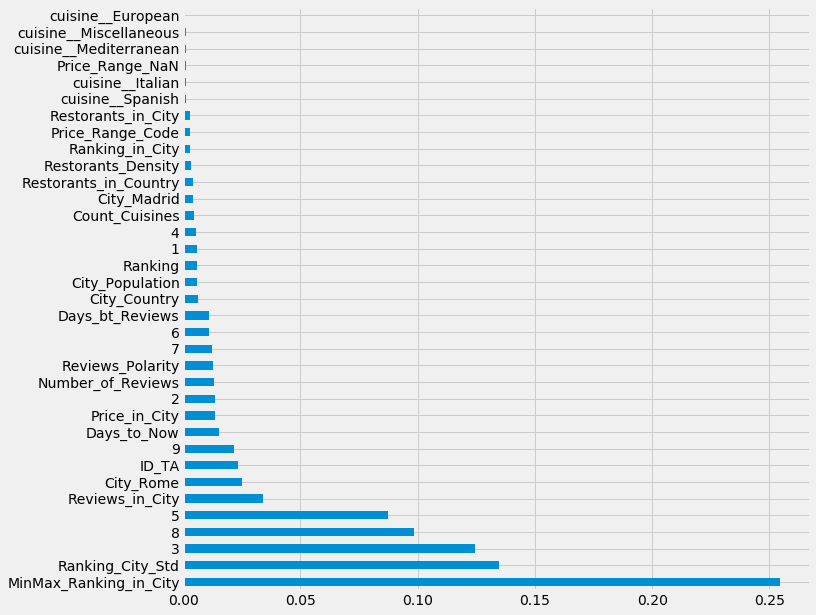

In [1077]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(35).plot(kind='barh');

## * * * * Submission * * * *

In [1078]:
test_data.sample(10)

,Ranking,Number_of_Reviews,ID_TA,Rating,Number_of_Reviews_NaN,Reviews_NaN,Price_Range_NaN,Price_Range_Code,Count_Cuisines,Top10_Cuisine,...,cuisine__Ukrainian,cuisine__Uzbek,cuisine__Vegan Options,cuisine__Vegetarian Friendly,cuisine__Venezuelan,cuisine__Vietnamese,cuisine__Welsh,cuisine__Wine Bar,cuisine__Xinjiang,cuisine__Yunnan
5,5093.0,24.0,8458643,0.0,0.0,0.0,0.0,1,3,1,...,0,0,0,0,0,0,0,0,0,0
7929,1884.0,15.0,1012041,0.0,0.0,0.0,1.0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
8238,3515.0,288.0,2384908,0.0,0.0,0.0,0.0,2,2,1,...,0,0,0,0,0,0,0,0,0,0
5894,9529.0,10.0,7693485,0.0,0.0,0.0,1.0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
5962,2640.0,9.0,7009281,0.0,0.0,0.0,1.0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4397,6003.0,8.0,10430060,0.0,0.0,0.0,1.0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
7703,1738.0,111.0,7078653,0.0,0.0,0.0,0.0,2,3,1,...,0,0,0,0,0,0,0,0,0,0
8069,823.0,275.0,1406442,0.0,0.0,0.0,0.0,3,2,1,...,0,0,0,1,0,0,0,0,0,0
9441,4050.0,0.0,12685978,0.0,1.0,0.0,1.0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
5025,137.0,890.0,1315975,0.0,0.0,0.0,0.0,2,4,1,...,0,0,0,1,0,0,0,0,0,0


In [1079]:
test_data = test_data.drop(['Rating'], axis=1)

In [1080]:
sample_submission

,Restaurant_id,Rating
0,id_0,3.215
1,id_1,4.085
2,id_2,4.450
3,id_3,4.375
4,id_4,4.490
...,...,...
9995,id_9995,4.450
9996,id_9996,4.080
9997,id_9997,3.005
9998,id_9998,4.365


In [1081]:
predict_submission = model.predict(test_data)
predict_submission

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


array([3.055, 4.105, 4.385, ..., 2.985, 4.475, 4.41 ])

In [1082]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)
sample_submission.Rating.value_counts()

5.000    271
4.000    180
4.060     70
4.005     69
4.505     68
        ... 
2.080      1
2.690      1
1.715      1
2.010      1
1.880      1
Name: Rating, Length: 626, dtype: int64